RCNN - KERAS - NOTEBOOK

In [15]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys

In [3]:
path = "Image"
label = "Label"

In [4]:
def getface(df):
    for row in df.iterrows():
        x1 = int((row[1][0].split(" ")[0]).split(".")[0])
        y1 = int((row[1][0].split(" ")[1]).split(".")[0])
        x2 = int((row[1][0].split(" ")[2]).split(".")[0])
        y2 = int((row[1][0].split(" ")[3]).split(".")[0])
    return x1, y1, x2, y2    

On affiche une image avec les cordonnée données

In [12]:
path = "Image"
filename = "3.jpg"

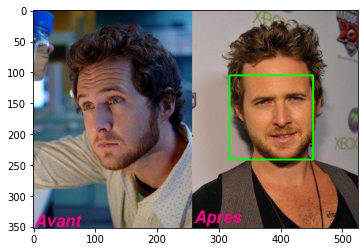

In [13]:
img = cv2.imread(os.path.join(path,filename))
df = pd.read_csv(os.path.join(label,filename[:-4]+".csv"))

x1, y1, x2, y2 = getface(df)
cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0), 2)
        
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

edge_detection

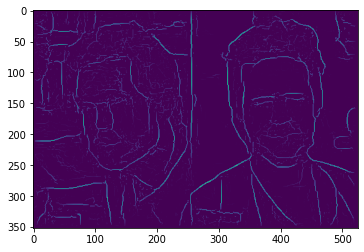

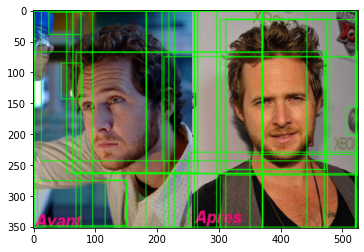

In [17]:
model = "model/model.yml"
cv2.setUseOptimized(True);
edge_detection = cv2.ximgproc.createStructuredEdgeDetection(model)

def get_boxes(img):
    rgb_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    edges = edge_detection.detectEdges(np.float32(rgb_im) / 255.0)

    orimap = edge_detection.computeOrientation(edges)
    edges = edge_detection.edgesNms(edges, orimap)

    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(30) 
    return edge_boxes.getBoundingBoxes(edges, orimap),edges

img = cv2.imread(os.path.join(path,filename))
boxes, edges = get_boxes(img)
for b in boxes[0]:
    x, y, w, h = b
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

plt.imshow(edges)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Normale

In [18]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

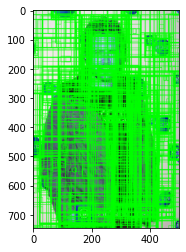

In [20]:
im = cv2.imread(os.path.join(path,"0.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()

for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

plt.imshow(imOut)

In [6]:
train_images=[]
train_labels=[]

In [7]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [8]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [9]:
c = 0
for e,i in enumerate(os.listdir(label)):
    try:
        filename = i.split(".")[0]+".jpg"
        print(e,filename)
        image = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(label,i))
        gtvalues=[]
        
        x1, y1, x2, y2 = getface(df)
        gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        
        ## with normal boxe
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        boxes = ss.process()
        
        ## or with edge box
        boxes = get_boxes(image)[0]
        
        imout = image.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        c += 1
        if c > 1000:#Numver d'image
            break
        for e,result in enumerate(boxes):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if counter < 30:
                        if iou > 0.70:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")
                    flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 0.jpg
1 1.jpg
2 10.jpg
3 1000.jpg
4 10002.jpg
5 10003.jpg
6 10004.jpg
7 10005.jpg
8 10006.jpg
9 10007.jpg
10 10009.jpg
11 1001.jpg
12 10011.jpg
13 10013.jpg
14 10014.jpg
15 10015.jpg
16 10016.jpg
17 10017.jpg
18 10019.jpg
19 10020.jpg
20 10021.jpg
21 10022.jpg
22 10023.jpg
23 10025.jpg
24 10029.jpg
25 10031.jpg
26 10032.jpg
27 10033.jpg
28 10034.jpg
29 10038.jpg
30 10039.jpg
31 10041.jpg
32 10042.jpg
33 10043.jpg
34 10044.jpg
35 10046.jpg
36 10047.jpg
37 10048.jpg
38 10049.jpg
39 1005.jpg
40 10050.jpg
41 10051.jpg
42 10052.jpg
43 10053.jpg
44 10056.jpg
45 10057.jpg
46 10058.jpg
47 10059.jpg
48 10060.jpg
49 10061.jpg
50 10062.jpg
51 10063.jpg
52 10066.jpg
53 10067.jpg
54 10068.jpg
55 1007.jpg
56 10071.jpg
57 10072.jpg
58 10073.jpg
59 10074.jpg
60 10075.jpg
61 10077.jpg
62 10078.jpg
63 10079.jpg
64 1008.jpg
65 10080.jpg
66 10081.jpg
67 10084.jpg
68 10085.jpg
69 10086.jpg
70 10089.jpg
71 1009.jpg
72 10091.jpg
73 10092.jpg
74 10093.jpg
75 10094.jpg
76 10095.jpg
77 10096.jpg
78 10097.jpg


598 10803.jpg
599 10804.jpg
600 10805.jpg
601 10809.jpg
602 1081.jpg
603 10811.jpg
604 10812.jpg
605 10813.jpg
606 10814.jpg
607 10815.jpg
608 10816.jpg
609 10817.jpg
610 10819.jpg
611 1082.jpg
612 10820.jpg
613 10821.jpg
614 10822.jpg
615 10823.jpg
616 10824.jpg
617 10825.jpg
618 10826.jpg
619 10827.jpg
620 10828.jpg
621 1083.jpg
622 10830.jpg
623 10831.jpg
624 10832.jpg
625 10833.jpg
626 10835.jpg
627 10837.jpg
628 10838.jpg
629 10839.jpg
630 1084.jpg
631 10843.jpg
632 10844.jpg
633 10845.jpg
634 10846.jpg
635 10848.jpg
636 10849.jpg
637 1085.jpg
638 10850.jpg
639 10851.jpg
640 10852.jpg
641 10855.jpg
642 10856.jpg
643 10857.jpg
644 10858.jpg
645 10859.jpg
646 1086.jpg
647 10860.jpg
648 10862.jpg
649 10863.jpg
650 10865.jpg
651 10866.jpg
652 10867.jpg
653 10871.jpg
654 10872.jpg
655 10874.jpg
656 10875.jpg
657 10878.jpg
658 10879.jpg
659 1088.jpg
660 10882.jpg
661 10884.jpg
662 10886.jpg
663 1089.jpg
664 10893.jpg
665 10894.jpg
666 10895.jpg
667 10896.jpg
668 10898.jpg
669 109.jpg
67

In [10]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [11]:
X_new.shape

(32727, 224, 224, 3)

In [12]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [13]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [15]:
X= vggmodel.layers[-2].output

In [16]:
predictions = Dense(2, activation="softmax")(X)

In [17]:
model_final = Model(vggmodel.input,predictions)

In [18]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)

In [19]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [20]:
model_final.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [22]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [23]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [24]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [25]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(29454, 224, 224, 3) (3273, 224, 224, 3) (29454, 2) (3273, 2)


In [26]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train[:10000], y=y_train[:10000],batch_size=32)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test,batch_size=32)

In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [28]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [29]:
hist = model_final.fit(traindata, steps_per_epoch= 10, epochs= 10, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.4469 - accuracy: 0.8906
Epoch 00001: val_loss improved from inf to 0.18052, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 12s 1s/step - loss: 0.4469 - accuracy: 0.8906 - val_loss: 0.1805 - val_accuracy: 0.9844
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9906
Epoch 00002: val_loss improved from 0.18052 to 0.03472, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 9s 943ms/step - loss: 0.0597 - accuracy: 0.9906 - val_loss: 0.0347 - val_accuracy: 0.9844
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.9906
Epoch 00003: val_loss did not improve from 0.03472
10/10 [==============================] - 4s 390ms/step - loss: 0.1216 - accuracy: 0.9906 - val_loss: 0.6165 - val_accuracy: 0.8750
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.9750
Ep

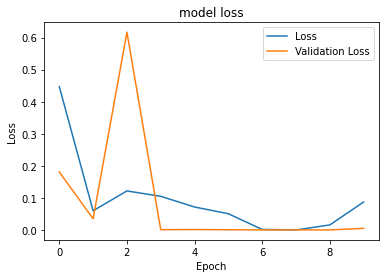

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [64]:
model_final.save('my_model.h5')

plane


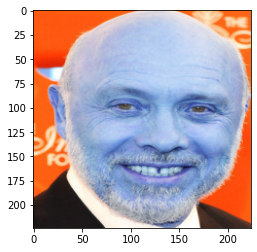

In [60]:
im = X_test[44]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

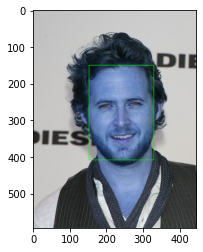

In [74]:
z=0
i = "6.jpg"
img = cv2.imread(os.path.join(path,i))
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < 3000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_final.predict(img)
        if out[0][0] > 0.65:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)  
            break
    else:
        break
plt.figure()
plt.imshow(cv2.cvtColor(imout, cv2.COLOR_BGR2RGB))


Load and Try

In [1]:
from keras.models import load_model

model_final= load_model('my_model.h5')



In [38]:
import time
from tensorflow.python.client import device_lib
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)


Num GPUs Available:  1


In [39]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
path = "Detector/Image"
i = "1.jpg"

cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
img = cv2.imread(os.path.join(path,i), cv2.COLOR_BGR2RGB)
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
a = time.time()
for e,result in enumerate(ssresults):
    x,y,w,h = result
    timage = imout[y:y+h,x:x+w]
    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
    img = np.expand_dims(resized, axis=0)
    with tf.device('/device:GPU:0'):
        out= model_final.predict(img)
        if out[0][0] > 0.65:
            b = time.time()
            print(b-a)
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 2, cv2.LINE_AA)  
            break
plt.figure()
plt.imshow(cv2.cvtColor(imout, cv2.COLOR_BGR2RGB))

0.0518946647644043


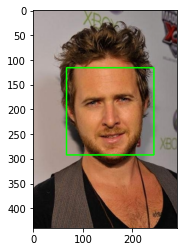

In [27]:
a = time.time()
img = cv2.imread(os.path.join(path,i))
detector = cv2.CascadeClassifier('model/haarcascade_frontalface_default.xml');
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY);
faces = detector.detectMultiScale(gray, 1.3, 5);
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
b = time.time()
print(b-a)